In [224]:
import pickle, tensorflow as tf, numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, SpatialDropout1D,
                                     Bidirectional, LSTM,
                                     TimeDistributed, Dense)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter

In [225]:
data = []
with open("../dataset/new_ner_srl.tsv", encoding="utf-8") as f:
    tok, ner, srl = [], [], []
    for line in f:
        line = line.strip()
        if not line:
            if tok:
                data.append({"tokens": tok, "labels_ner": ner, "labels_srl": srl})
                tok, ner, srl = [], [], []
        else:
            t, n, s = line.split("\t")
            tok.append(t.lower())
            ner.append(n)
            srl.append(s)
# ——————————————————
sentences  = [d["tokens"]      for d in data]
labels_ner = [d["labels_ner"]  for d in data]
labels_srl = [d["labels_srl"]  for d in data]

ner_counter = Counter(label for seq in labels_ner for label in seq)

srl_counter = Counter(label for seq in labels_srl for label in seq)

print("Total per label NER:")
for label, count in ner_counter.items():
    print(f"{label}: {count}")

print("\nTotal per label SRL:")
for label, count in srl_counter.items():
    print(f"{label}: {count}")

Total per label NER:
O: 2724
B-TIME: 121
B-PER: 281
B-LOC: 443
I-PER: 223
B-DATE: 324
I-DATE: 640
B-ETH: 219
I-ETH: 224
B-EVENT: 37
I-EVENT: 19
I-LOC: 13
I-TIME: 1
B-ORG: 11
I-ORG: 8

Total per label SRL:
O: 1489
ARGM-TMP: 1096
ARG0: 827
V: 478
ARG1: 929
ARGM-LOC: 361
ARG2: 98
ARGM-MOD: 5
ARGM-MNR: 5


In [226]:
PAD_TOKEN = "<PAD>"
words     = sorted({w for s in sentences for w in s})
print(words)
ner_tags  = sorted({t for seq in labels_ner for t in seq})
srl_tags  = sorted({t for seq in labels_srl for t in seq})

ner_tags.insert(0, PAD_TOKEN)
srl_tags.insert(0, PAD_TOKEN)

word2idx          = {w: i + 2 for i, w in enumerate(words)}
word2idx["PAD"]   = 0
word2idx["UNK"]   = 1

tag2idx_ner = {t: i for i, t in enumerate(ner_tags)}
tag2idx_srl = {t: i for i, t in enumerate(srl_tags)}
idx2tag_ner = {i: t for t, i in tag2idx_ner.items()}
idx2tag_srl = {i: t for t, i in tag2idx_srl.items()}

['.', '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30', '08:15', '08:30', '08:45', '09:15', '09:30', '09:45', '1', '10', '10:00', '10:15', '10:30', '11', '11:00', '11:15', '11:45', '12', '12:15', '12:30', '12:45', '13', '13:15', '13:30', '13:45', '14', '14:15', '14:30', '14:45', '15', '15:00', '16', '1683', '16:00', '16:15', '16:30', '16:45', '17', '17:45', '18', '1825', '1879', '18:30', '19', '1902', '1928', '1945', '1948', '1949', '1959', '1965', '1970', '1999', '19:00', '19:15', '19:45', '2', '20', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '20:30', '21', '21:00', '21:15', '21:45', '22', '22:15', '23', '23:30', '24', '25', '26', '27', '28', '3', '4', '5', '6', '7', '73', '8', '9', 'a.h.', 'abad', 'abdul', 'abdurrahman', 'acara', 'aceh', 'adalah', 'adat', 'agenda', 'ageng', 'agung', 'agus', 'agustus', 'ahmad'

In [227]:
X     = [[word2idx.get(w, 1) for w in s] for s in sentences]
y_ner = [[tag2idx_ner[t]     for t in seq] for seq in labels_ner]
y_srl = [[tag2idx_srl[t]     for t in seq] for seq in labels_srl]

maxlen = max(map(len, X))
pad_id = tag2idx_ner[PAD_TOKEN]

X     = pad_sequences(X,     maxlen=maxlen, padding="post", value=0)
y_ner = pad_sequences(y_ner, maxlen=maxlen, padding="post", value=pad_id)
y_srl = pad_sequences(y_srl, maxlen=maxlen, padding="post", value=pad_id)

mask   = (y_ner != pad_id).astype("float32")   # shape (N, L)


In [228]:
splits = train_test_split(X, y_ner, y_srl, mask,
                          test_size=0.2, random_state=42, shuffle=True)
X_tr, X_te, ner_tr, ner_te, srl_tr, srl_te, m_tr, m_te = splits


In [229]:
embed_dim  = 64
lstm_units = 64
drop_embed = 0.45
drop_lstm  = 0.35

inp  = Input(shape=(maxlen,), name="tokens")
emb  = Embedding(len(word2idx),
                 embed_dim,
                 mask_zero=True,
                 name="embed")(inp)
emb  = SpatialDropout1D(drop_embed)(emb)

x = Bidirectional(LSTM(lstm_units,
                       return_sequences=True,
                       dropout=drop_lstm,
                       recurrent_dropout=drop_lstm))(emb)
x = Bidirectional(LSTM(lstm_units,
                       return_sequences=True,
                       dropout=drop_lstm,
                       recurrent_dropout=drop_lstm))(x)

ner_head = TimeDistributed(Dense(lstm_units, activation="relu"))(x)
ner_out  = TimeDistributed(Dense(len(tag2idx_ner),
                                 activation="softmax"),
                           name="ner_output")(ner_head)

srl_head = TimeDistributed(Dense(lstm_units, activation="relu"))(x)
srl_out  = TimeDistributed(Dense(len(tag2idx_srl),
                                 activation="softmax"),
                           name="srl_output")(srl_head)

model = Model(inp, [ner_out, srl_out])

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss={
        "ner_output": "sparse_categorical_crossentropy",
        "srl_output": "sparse_categorical_crossentropy",
    },
    metrics={
        "ner_output": ["sparse_categorical_accuracy"],
        "srl_output": ["sparse_categorical_accuracy"],
    },
    # sample_weight_mode="temporal"
)
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tokens (InputLayer) │ (None, 22)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 22, 64)    │     41,664 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 22, 64)    │          0 │ embed[0][0]       │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_18        │ (None, 22)        │          0 │ tokens[0][0]      │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_36    │ (None, 22, 128)   │     66,048 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_37    │ (None, 22, 128)   │     98,816 │ bidirectional_36… │
│ (Bidirectional)     │                   │            │ not_equal_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_34 │ (None, 22, 64)    │      8,256 │ bidirectional_37… │
│ (TimeDistributed)   │                   │            │ not_equal_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_35 │ (None, 22, 64)    │      8,256 │ bidirectional_37… │
│ (TimeDistributed)   │                   │            │ not_equal_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_output          │ (None, 22, 16)    │      1,040 │ time_distributed… │
│ (TimeDistributed)   │                   │            │ not_equal_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_output          │ (None, 22, 10)    │        650 │ time_distributed… │
│ (TimeDistributed)   │                   │            │ not_equal_18[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 224,730 (877.85 KB)

 Trainable params: 224,730 (877.85 KB)

 Non-trainable params: 0 (0.00 B)

In [230]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5),
]

history = model.fit(
    X_tr,
    [ner_tr, srl_tr],          # y → LIST (pos 0 = ner_output, 1 = srl_output)
    sample_weight=[m_tr, m_tr],# sama‑persis urutan
    validation_data=(
        X_te,
        [ner_te, srl_te],
        [m_te,  m_te]
    ),
    batch_size=2,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)



# =========================
# 7.  Save artefacts
# =========================
model.save("lstm_ner_srl_model.keras")
for fname, obj in [("word2idx.pkl", word2idx),
                   ("tag2idx_ner.pkl", tag2idx_ner),
                   ("tag2idx_srl.pkl", tag2idx_srl)]:
    with open(fname, "wb") as f:
        pickle.dump(obj, f)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 4.4003 - ner_output_loss: 2.3921 - ner_output_sparse_categorical_accuracy: 0.2545 - srl_output_loss: 2.0082 - srl_output_sparse_categorical_accuracy: 0.1825 - val_loss: 2.8942 - val_ner_output_loss: 1.5137 - val_ner_output_sparse_categorical_accuracy: 0.2742 - val_srl_output_loss: 1.3805 - val_srl_output_sparse_categorical_accuracy: 0.2340 - learning_rate: 3.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 2.7142 - ner_output_loss: 1.4036 - ner_output_sparse_categorical_accuracy: 0.2803 - srl_output_loss: 1.3106 - srl_output_sparse_categorical_accuracy: 0.2522 - val_loss: 2.7169 - val_ner_output_loss: 1.3986 - val_ner_output_sparse_categorical_accuracy: 0.2732 - val_srl_output_loss: 1.3184 - val_srl_output_sparse_categorical_accuracy: 0.2553 - learning_rate: 3.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 2.4396 - ner_output_loss: 1.2882 - ner_output_sparse_categorical_accuracy: 0

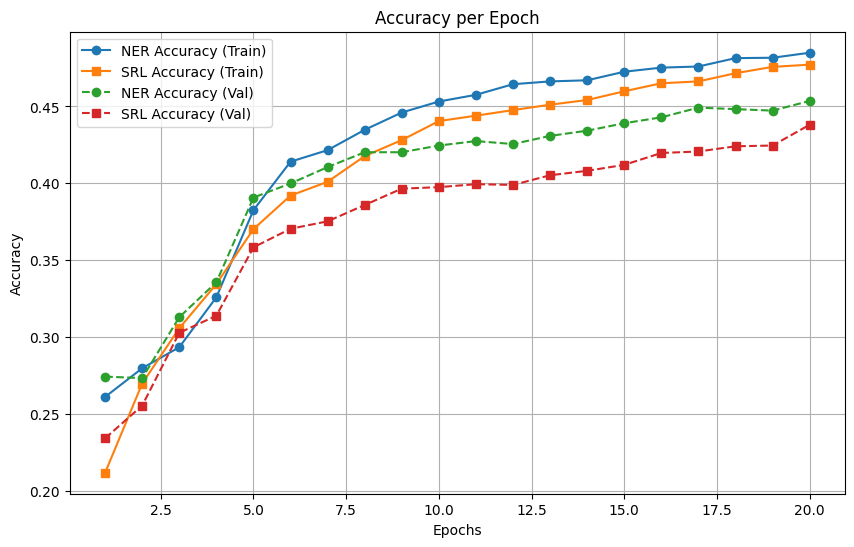

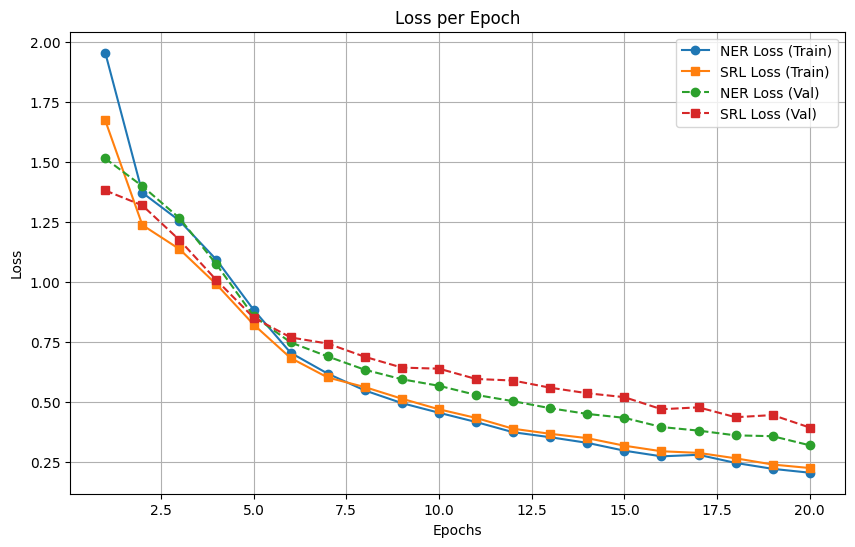

In [231]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Extract data from history
    history_data = history.history
    epochs = range(1, len(history_data['ner_output_sparse_categorical_accuracy']) + 1)

    # --- Plot Accuracy ---
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history_data['ner_output_sparse_categorical_accuracy'], marker='o', label='NER Accuracy (Train)')
    plt.plot(epochs, history_data['srl_output_sparse_categorical_accuracy'], marker='s', label='SRL Accuracy (Train)')

    if 'val_ner_output_sparse_categorical_accuracy' in history_data:
        plt.plot(epochs, history_data['val_ner_output_sparse_categorical_accuracy'], marker='o', linestyle='--', label='NER Accuracy (Val)')
        plt.plot(epochs, history_data['val_srl_output_sparse_categorical_accuracy'], marker='s', linestyle='--', label='SRL Accuracy (Val)')

    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_plot.png')  # Save the accuracy plot
    plt.show()

    # --- Plot Loss ---
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history_data['ner_output_loss'], marker='o', label='NER Loss (Train)')
    plt.plot(epochs, history_data['srl_output_loss'], marker='s', label='SRL Loss (Train)')

    if 'val_ner_output_loss' in history_data:
        plt.plot(epochs, history_data['val_ner_output_loss'], marker='o', linestyle='--', label='NER Loss (Val)')
        plt.plot(epochs, history_data['val_srl_output_loss'], marker='s', linestyle='--', label='SRL Loss (Val)')

    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')  # Save the loss plot
    plt.show()

plot_training_history(history)


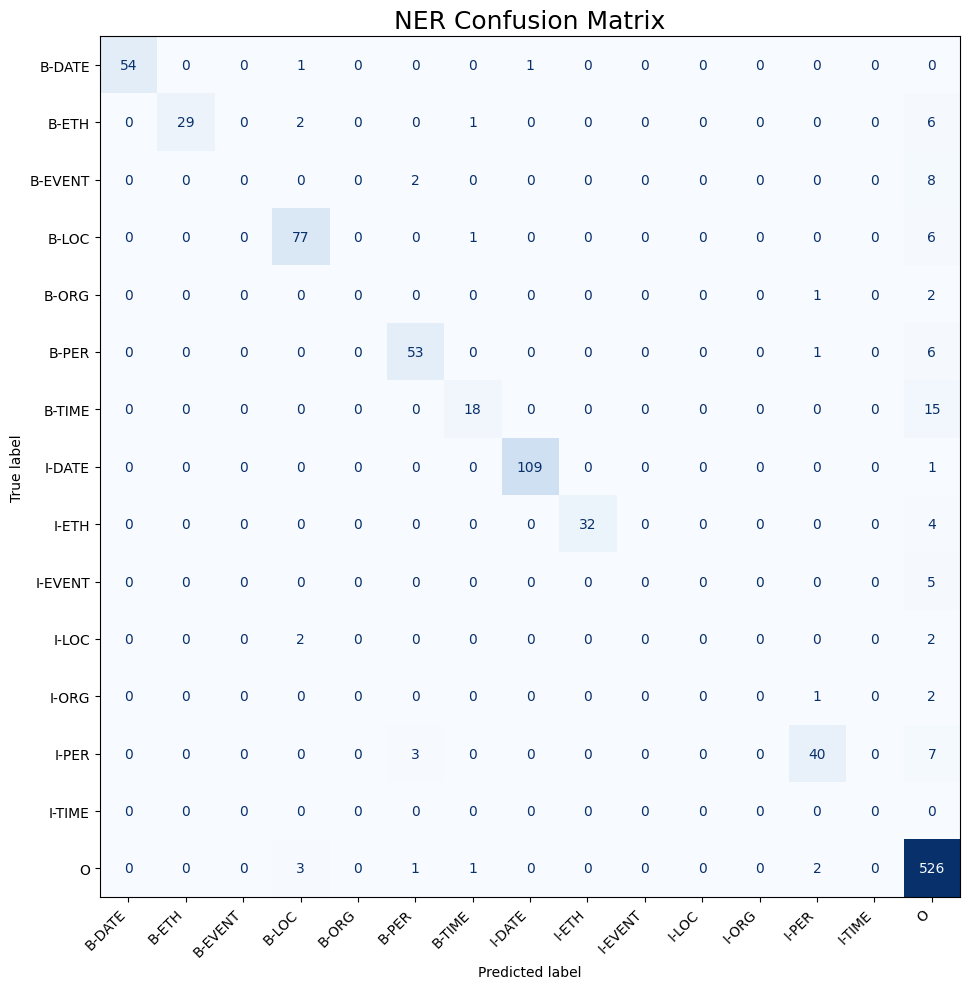

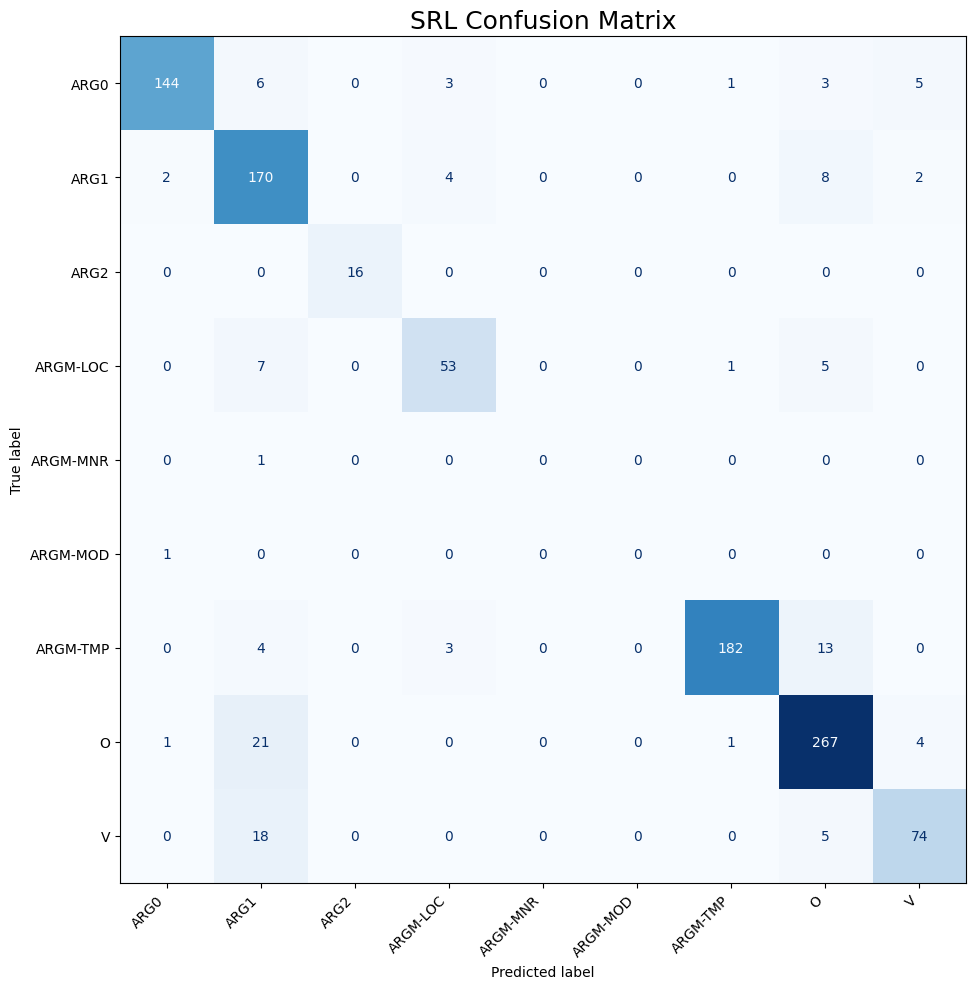

In [232]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ------------------------------------------------------------------
# 1.  Prediksi
# ------------------------------------------------------------------
pred_ner_prob, pred_srl_prob = model.predict(X_te, verbose=0)

pred_ner = pred_ner_prob.argmax(-1)
pred_srl = pred_srl_prob.argmax(-1)

# ------------------------------------------------------------------
# 2.  Siapkan masker PAD
# ------------------------------------------------------------------
pad_id = tag2idx_ner["<PAD>"]

mask_ner = (ner_te != pad_id)
mask_srl = (srl_te != pad_id)

true_ner_flat = ner_te[mask_ner]
pred_ner_flat = pred_ner[mask_ner]

true_srl_flat = srl_te[mask_srl]
pred_srl_flat = pred_srl[mask_srl]

# ------------------------------------------------------------------
# 3.  Hitung confusion matrix TANPA PAD
# ------------------------------------------------------------------
# Buang ID PAD dari label list
labels_ner_no_pad = [i for i in range(len(tag2idx_ner)) if i != pad_id]
labels_srl_no_pad = [i for i in range(len(tag2idx_srl)) if i != pad_id]

cm_ner = confusion_matrix(
    true_ner_flat, pred_ner_flat,
    labels=labels_ner_no_pad
)

cm_srl = confusion_matrix(
    true_srl_flat, pred_srl_flat,
    labels=labels_srl_no_pad
)

# Siapkan label display TANPA PAD
display_labels_ner = [idx2tag_ner[i] for i in labels_ner_no_pad]
display_labels_srl = [idx2tag_srl[i] for i in labels_srl_no_pad]

# ------------------------------------------------------------------
# 4.  Plot NER CM (tanpa PAD)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))
disp_ner = ConfusionMatrixDisplay(
    confusion_matrix=cm_ner,
    display_labels=display_labels_ner
)
disp_ner.plot(
    include_values=True,            # Tampilkan angka
    values_format='d',              # Format integer
    cmap=plt.cm.Blues,              # Biru-putih
    ax=ax,
    colorbar=False
)
ax.set_title("NER Confusion Matrix", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 5.  Plot SRL CM (tanpa PAD)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))
disp_srl = ConfusionMatrixDisplay(
    confusion_matrix=cm_srl,
    display_labels=display_labels_srl
)
disp_srl.plot(
    include_values=True,
    values_format='d',
    cmap=plt.cm.Blues,
    ax=ax,
    colorbar=False
)
ax.set_title("SRL Confusion Matrix", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [233]:
from sklearn.metrics import accuracy_score, classification_report

# ------------------------------------------------------------------
# 3b.  Akurasi token‑level (tanpa PAD)
# ------------------------------------------------------------------
acc_ner = accuracy_score(true_ner_flat, pred_ner_flat)
acc_srl = accuracy_score(true_srl_flat, pred_srl_flat)

print(f"NER TAG accuracy : {acc_ner:.2%}")
print(f"SRL TAG accuracy : {acc_srl:.2%}")






NER TAG accuracy : 91.51%
SRL TAG accuracy : 88.39%


In [234]:
# (Opsional) tampilkan ringkasan metrik per‑label
print("\n[NER] Classification report:")
print(classification_report(true_ner_flat, pred_ner_flat,
                            labels=labels_ner_no_pad,
                            target_names=display_labels_ner,
                            digits=2))


[NER] Classification report:
              precision    recall  f1-score   support

      B-DATE       1.00      0.96      0.98        56
       B-ETH       1.00      0.76      0.87        38
     B-EVENT       0.00      0.00      0.00        10
       B-LOC       0.91      0.92      0.91        84
       B-ORG       0.00      0.00      0.00         3
       B-PER       0.90      0.88      0.89        60
      B-TIME       0.86      0.55      0.67        33
      I-DATE       0.99      0.99      0.99       110
       I-ETH       1.00      0.89      0.94        36
     I-EVENT       0.00      0.00      0.00         5
       I-LOC       0.00      0.00      0.00         4
       I-ORG       0.00      0.00      0.00         3
       I-PER       0.89      0.80      0.84        50
      I-TIME       0.00      0.00      0.00         0
           O       0.89      0.99      0.94       533

    accuracy                           0.92      1025
   macro avg       0.56      0.52      0.54      1

/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [235]:
print("\n[SRL] Classification report:")
print(classification_report(true_srl_flat, pred_srl_flat,
                            labels=labels_srl_no_pad,
                            target_names=display_labels_srl,
                            digits=2))


[SRL] Classification report:
              precision    recall  f1-score   support

        ARG0       0.97      0.89      0.93       162
        ARG1       0.75      0.91      0.82       186
        ARG2       1.00      1.00      1.00        16
    ARGM-LOC       0.84      0.80      0.82        66
    ARGM-MNR       0.00      0.00      0.00         1
    ARGM-MOD       0.00      0.00      0.00         1
    ARGM-TMP       0.98      0.90      0.94       202
           O       0.89      0.91      0.90       294
           V       0.87      0.76      0.81        97

    accuracy                           0.88      1025
   macro avg       0.70      0.69      0.69      1025
weighted avg       0.89      0.88      0.88      1025



/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [236]:

# def plot_training_history(history):
#     epochs = range(1, len(history['loss']) + 1)

#     plt.figure(figsize=(14, 6))

#     # Plot Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, history['loss'], label='Training Loss')
#     plt.plot(epochs, history['val_loss'], label='Validation Loss')
#     plt.title('Loss During Training')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plot Accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, history['ner_output_accuracy'], label='NER Train Acc')
#     plt.plot(epochs, history['val_ner_output_accuracy'], label='NER Val Acc')
#     plt.plot(epochs, history['srl_output_accuracy'], label='SRL Train Acc')
#     plt.plot(epochs, history['val_srl_output_accuracy'], label='SRL Val Acc')
#     plt.title('Accuracy During Training')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()
    
# plot_training_history(history.history)


In [237]:
# def token_level_accuracy(y_true, y_pred):
#     total, correct = 0, 0
#     for true_seq, pred_seq in zip(y_true, y_pred):
#         for t, p in zip(true_seq, pred_seq):
#             if t.sum() == 0:
#                 continue
#             total += 1
#             if t.argmax() == p.argmax():
#                 correct += 1
#     return correct / total

# def decode_predictions(pred, true, idx2tag):
#     true_out, pred_out = [], []
#     for pred_seq, true_seq in zip(pred, true):
#         t_labels, p_labels = [], []
#         for p_tok, t_tok in zip(pred_seq, true_seq):
#             if t_tok.sum() == 0:
#                 continue
#             t_labels.append(idx2tag[t_tok.argmax()])
#             p_labels.append(idx2tag[p_tok.argmax()])
#         true_out.append(t_labels)
#         pred_out.append(p_labels)
#     return true_out, pred_out

# results = model.evaluate(X_test, {"ner_output": y_ner_test, "srl_output": y_srl_test}, verbose=0)
# for name, value in zip(model.metrics_names, results):
#     print(f"{name}: {value}")

# y_pred_ner, y_pred_srl = model.predict(X_test, verbose=0)

# true_ner, pred_ner = decode_predictions(y_pred_ner, y_ner_test, idx2tag_ner)
# true_srl, pred_srl = decode_predictions(y_pred_srl, y_srl_test, idx2tag_srl)

# acc_ner = token_level_accuracy(y_ner_test, y_pred_ner)
# acc_srl = token_level_accuracy(y_srl_test, y_pred_srl)

# print(f"NER Token Accuracy {acc_ner:.2%}")
# print(f"SRL Token Accuracy {acc_srl:.2%}")



In [238]:
# print("[NER] Classification Report:")
# print(classification_report(true_ner, pred_ner, digits=2))

In [239]:
# print("SRL Classification Resport:")
# print(classification_report(true_srl, pred_srl, digits=2))